# Logistic Regression Model

## Data Import And Cleaning

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf

C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv',
               '../../data/cleaned/utah_2017_bird.csv']

test_files = ['../../data/cleaned/utah_2018_vineyard.csv', 
               '../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']
x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

# TODO Create average off of minor bloom
RFU_THRESHOLD = 1.2
train_index = 0
test_index = 1

In [4]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


In [5]:
test_dfs[test_index].head()

,Time America/Boise UTC-06:00,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,4/11/2018 10:30,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6
1,4/11/2018 10:45,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6
2,4/11/2018 11:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7
3,4/11/2018 11:15,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7
4,4/11/2018 11:30,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7


In [6]:
train_dfs[train_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000
mean,18.488235,1933.564575,-116.806951,8.633415,58.129348,87.056980,8.179008,0.979511
std,6.134464,151.800551,8.973830,0.147231,54.622278,13.793755,1.278416,0.731423
min,5.630000,3.000000,-153.700000,7.930000,0.660000,62.800000,5.170000,0.000000
25%,12.700000,1848.000000,-120.800000,8.530000,29.850000,80.000000,7.260000,0.500000
50%,20.320000,1939.000000,-115.700000,8.650000,42.140000,83.200000,8.080000,0.900000
75%,23.630000,2070.000000,-112.100000,8.700000,65.795000,88.900000,9.250000,1.200000
max,28.570000,2164.000000,-76.500000,9.230000,636.700000,209.700000,16.170000,16.100000


In [7]:
test_dfs[test_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000
mean,19.131184,1990.294607,-196.624329,8.922357,63.929067,90.057202,8.309566,1.459773
std,5.045367,230.743946,27.769024,0.357733,70.885989,17.627283,1.486747,1.311960
min,0.000000,0.000000,-284.000000,0.000000,-0.880000,0.000000,0.000000,-0.400000
25%,15.480000,1869.000000,-216.950000,8.730000,33.750000,79.100000,7.280000,0.600000
50%,20.190000,1958.000000,-192.000000,8.920000,48.380000,85.300000,8.010000,1.000000
75%,23.070000,2149.000000,-179.500000,9.100000,68.275000,95.300000,9.240000,1.700000
max,28.600000,2417.000000,0.000000,10.100000,1248.920000,245.500000,19.590000,21.100000


## Use Datetime Index

In [8]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                   int64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [11]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    train_timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    train_timestamp = pd.to_datetime(train_timestamp)
    train_dfs[i]['timestamp'] = train_timestamp
    train_dfs[i]['datetime'] = train_timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [12]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    test_timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = test_timestamp
    test_dfs[i]['datetime'] = test_timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00


## BGA RFU Levels

In [13]:
presegmented_plot = pd.DataFrame(
    {'BGA RFU': train_dfs[train_index][target_column], 
     'Bloom Threshold': np.full(train_dfs[train_index].count()[0], RFU_THRESHOLD)})

In [14]:
def windowize(df, time_column):
    print("Segmenting...")
    x_windows, y_windows = hf.segment_dataset(df, time_column)
    print("Extracting feature windows...")
    x_windows = hf.extract_percentile(x_windows, time_column)
    print("Extracting target windows...")
    y_windows = hf.extract_percentile(y_windows, time_column)
    print("Combining extractions...")
    x_windows[target_column] = y_windows[target_column].values
    return x_windows

In [15]:
# Segment each data frame
for i in range(0, len(train_dfs)):
    print("Windowizing 2017 data set:", i+1)
    train_dfs[i] = windowize(train_dfs[i], 'datetime')
    print("Windowizing 2018 data set:", i+1)
    test_dfs[i] = windowize(test_dfs[i], 'datetime')
    print()

Windowizing 2017 data set: 1
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 1
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Windowizing 2017 data set: 2
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 2
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Windowizing 2017 data set: 3
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 3
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



In [16]:
for i in range(0, len(train_dfs)):
    train_dfs[i]['time of day'] = train_dfs[i]['datetime'].apply(hf.create_time_of_day).astype('category')
for i in range(0, len(test_dfs)):
    test_dfs[i]['time of day'] = test_dfs[i]['datetime'].apply(hf.create_time_of_day).astype('category')

In [19]:
train_dfs[train_index].head()

,BGA-Phycocyanin RFU,ODO (mg/L),ODOSat%,Sp Cond (uS/cm),Temp C,Turbidity (NTU),datetime,pH,pH (mV),time of day
datetimeIndex,,,,,,,,,,
2017-05-06 21:36:00,0.625,9.608,97.64,1901.2,16.57,84.926,2017-05-06 21:36:00,8.4,-99.70,evening
2017-05-06 22:36:00,0.625,9.608,97.64,1910.4,16.57,85.154,2017-05-06 22:36:00,8.4,-99.60,evening
2017-05-06 23:36:00,0.625,9.608,97.64,1914.0,16.57,88.782,2017-05-06 23:36:00,8.4,-99.50,evening
2017-05-07 00:36:00,0.625,9.608,97.64,1914.0,16.57,88.812,2017-05-07 00:36:00,8.4,-99.40,dawn
2017-05-07 01:36:00,0.625,9.608,97.64,1915.0,16.57,88.812,2017-05-07 01:36:00,8.4,-99.36,dawn


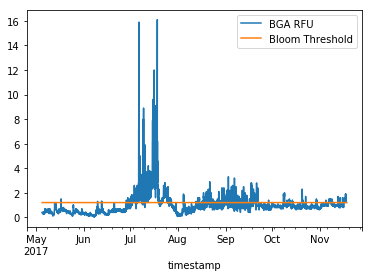

In [20]:
presegmented_plot.plot.line()

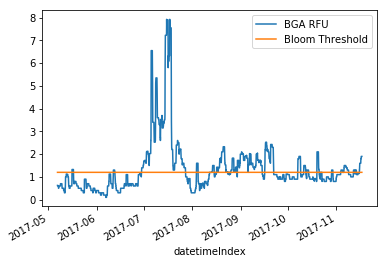

In [21]:
pd.DataFrame({'BGA RFU': train_dfs[train_index][target_column], 
            'Bloom Threshold': np.full(
                train_dfs[train_index].count()[0], RFU_THRESHOLD)}).plot.line()

## Logistic Regression Model

In [22]:
lrf.add_target_column([train_dfs[train_index], test_dfs[test_index]], 
                      threshold=RFU_THRESHOLD)

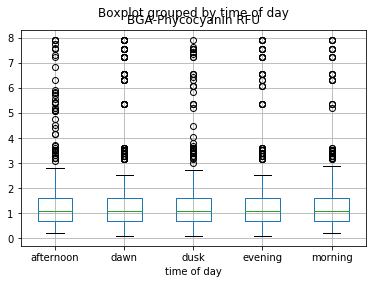

In [27]:
train_dfs[train_index].boxplot(column='BGA-Phycocyanin RFU', by='time of day')

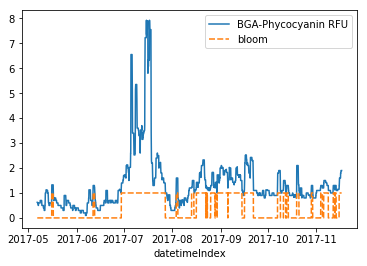

In [21]:
sns.lineplot(data=train_dfs[train_index][[target_column, 'bloom']], hue='bloom')

In [22]:
x_columns.append('time of day')

max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)

accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.646323682566132
Recall: 1.0
Precision 0.6213202497769849
Confusion Matrix:
 [[ 317 1698]
 [   0 2786]]


In [23]:

model = SGDClassifier(max_iter=max_iter, loss=loss)
# Sort columns by accuracy
sorted_columns = lrf.sort_columns_by_metric(model, train_dfs[train_index], 
                                            test_dfs[test_index],
                                            x_columns,
                                            'bloom')

Training model with: Temp C


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.6059154342845241
Recall: 0.416367552045944
Precision 0.8134642356241234
Confusion Matrix:
 [[1749  266]
 [1626 1160]]

Training model with: Sp Cond (uS/cm)


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 

Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]

Training model with: pH (mV)
Accuracy 0.5802957717142262
Recall: 1.0
Precision 0.5802957717142262
Confusion Matrix:
 [[   0 2015]
 [   0 2786]]

Training model with: pH


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.6854821912101645
Recall: 0.9178033022254127
Precision 0.6662324127149557
Confusion Matrix:
 [[ 734 1281]
 [ 229 2557]]

Training model with: Turbidity (NTU)


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 

Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]

Training model with: ODOSat%
Accuracy 0.7167256821495521
Recall: 0.6920315865039484
Precision 0.7934156378600823
Confusion Matrix:
 [[1513  502]
 [ 858 1928]]

Training model with: ODO (mg/L)


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.7042282857737971
Recall: 0.6826992103374013
Precision 0.7801476620180475
Confusion Matrix:
 [[1479  536]
 [ 884 1902]]

Training model with: time of day


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]

ODOSat% metric value: 0.7167256821495521
ODO (mg/L) metric value: 0.7042282857737971
pH metric value: 0.6854821912101645
Temp C metric value: 0.6059154342845241
pH (mV) metric value: 0.5802957717142262
Sp Cond (uS/cm) metric value: 0.4197042282857738
Turbidity (NTU) metric value: 0.4197042282857738
time of day metric value: 0.4197042282857738


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
#create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)

accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 
                                            'bloom', sorted_columns)


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 

Training model with: ['ODOSat%']
Test model accuracy: 0.7167256821495521
Test model recall: 0.6920315865039484
Test model precision: 0.7934156378600823

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7523432618204541
Test model recall: 0.7552045944005743
Test model precision: 0.8058215243201838

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH']


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7546344511560091
Test model recall: 0.8908829863603733
Test model precision: 0.7395709177592372

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C']


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7567173505519683
Test model recall: 0.8912419239052405
Test model precision: 0.741636798088411

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'pH (mV)']


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6398666944386586
Test model recall: 0.9712849964106246
Test model precision: 0.6213547646383467

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)']


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7865028119141846
Test model recall: 0.8851399856424982
Test model precision: 0.7776726584673604

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7865028119141846
Test model recall: 0.8851399856424982
Test model precision: 0.7776726584673604

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)', 'time of day']


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.78775255155176
Test model recall: 0.8851399856424982
Test model precision: 0.7791469194312797

Updating greedy model

Final greedy columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)', 'time of day']
Final greedy accuracy 0.78775255155176
Final greedy recall: 0.8851399856424982
Final greedy precision: 0.7791469194312797
Final greedy confusion matrix:
 [[1316  699]
 [ 320 2466]]


Model AUC: 0.8680


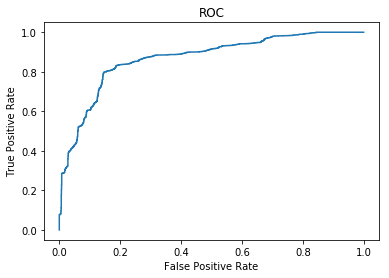

In [25]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test_dfs[test_index][['bloom']].values, predictions)

## Random Forest Model

In [26]:
# All Inputs
model = RandomForestClassifier(n_estimators=100)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

Accuracy 0.6619454280358259
Recall: 0.8517587939698492
Precision 0.6622941668992465
Confusion Matrix:
 [[ 805 1210]
 [ 413 2373]]


In [27]:
# Greedy Model
model = RandomForestClassifier(n_estimators=100)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom', sorted_columns)

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Training model with: ['ODOSat%']
Test model accuracy: 0.6781920433243074
Test model recall: 0.6923905240488155
Test model precision: 0.7371035536874283

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.6940220787335971
Test model recall: 0.7587939698492462
Test model precision: 0.7262109240810718

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH']
Test model accuracy: 0.6556967298479484
Test model recall: 0.6791098348887293
Test model precision: 0.7136929460580913

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test model accuracy: 0.6873568006665278
Test model recall: 0.7666905958363245
Test model precision: 0.7150987612989622

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH (mV)']
Test model accuracy: 0.5861278900229119
Test model recall: 0.9842067480258435
Test model precision: 0.5852721451440769

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Sp Cond (uS/cm)']
Test model accuracy: 0.6788169131430952


Model AUC: 0.7923


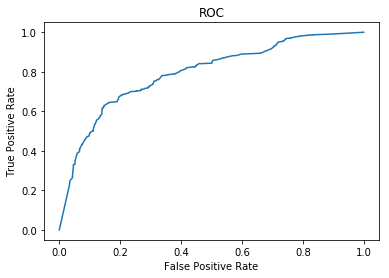

In [28]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test_dfs[test_index][['bloom']].values, predictions)